# Car Fuel Consumption 演習

https://www.kaggle.com/anderas/car-consume

In [195]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

## データ読み込みと、そのオリジナルデータの表示

- データ取得元
  - https://www.kaggle.com/anderas/car-consume/downloads/car-consume.zip/5

In [196]:
# 学習データを CSV ファイルから読み込む
df = pd.read_csv("../../car-consume/measurements.csv")
# オリジナルのデータを表示
display(df.head())
## specials カラムの値の確認
#df.groupby('specials').mean()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


## データの加工

In [197]:
# 小数点を表す文字を「,」から「.」に置換し、データを文字列型から浮動小数点型に変換する
df['distance'] = df['distance'].str.replace(',', '.').astype(float)
df['consume'] = df['consume'].str.replace(',', '.').astype(float)
df['temp_inside'] = df['temp_inside'].str.replace(',', '.').astype(float)
df['refill liters'] = df['refill liters'].str.replace(',', '.').astype(float)

# 空文字列を置換
# temp_inside カラムは、データ穴埋め後の全体への影響を最小限とするため、平均値で埋める
# refill liters　カラムは、値が無いことを示すため、0 で置換する
df['temp_inside'].fillna(df['temp_inside'].mean(), inplace=True)
df['refill liters'].fillna(0, inplace=True)

# specials カラムに、'AC' と 'ac'、'AC rain' と 'ac rain'、'AC sun' と 'AC Sun' と 'sun ac' が存在するので、
# それぞれ同じ値だとみなして、全体を小文字化したうえで、'ac'、'ac rain'、'ac sun' に寄せる
df['specials'] = df['specials'].str.lower()
df['specials'] = df['specials'].str.replace('sun ac', 'ac sun')
#df.groupby('specials').mean()

# pandas の get_dummies 関数を用いて、カテゴリ文字列値を持つカラム（ specials、gas_type、refill gas ）を数値で表すダミー変数に変換
df = pd.get_dummies(df)

- 元データ内の小数の表記が「 10,5 」のような形であったため、これを「 10.5 」のような形式に置換（ pandas の replace 関数を利用）

- 元データ内の、空データを置換（同カラムの平均値、あるいは0、から文字列に置換。pandas の fillna 関数を利用）

- カテゴリの文字列値を持つカラムについては、pandas の get_dummies 関数を用いて値を数値化する（specials、gas_type、refill gas）

## 加工済みデータを表示

- 加工済みデータの一部と、describe 関数の結果を表示

In [198]:
# データを表示
display(df.columns)
display(df.head())
df.describe()

Index(['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'AC',
       'rain', 'sun', 'refill liters', 'specials_ac', 'specials_ac rain',
       'specials_ac snow', 'specials_ac sun', 'specials_half rain half sun',
       'specials_rain', 'specials_snow', 'specials_sun', 'gas_type_E10',
       'gas_type_SP98', 'refill gas_E10', 'refill gas_SP98'],
      dtype='object')

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,specials_ac,...,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_rain,specials_snow,specials_sun,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98
0,28.0,5.0,26,21.5,12,0,0,0,45.0,0,...,0,0,0,0,0,0,1,0,1,0
1,12.0,4.2,30,21.5,13,0,0,0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
2,11.2,5.5,38,21.5,15,0,0,0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
3,12.9,3.9,36,21.5,14,0,0,0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
4,18.5,4.5,46,21.5,15,0,0,0,0.0,0,...,0,0,0,0,0,0,1,0,0,0


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,specials_ac,...,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_rain,specials_snow,specials_sun,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,...,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,1.243557,0.036082,...,0.002577,0.012887,0.002577,0.082474,0.007732,0.069588,0.412371,0.587629,0.012887,0.020619
std,22.667837,1.033172,13.598524,0.994666,6.991542,0.267443,0.329677,0.275441,6.856419,0.186736,...,0.050767,0.112931,0.050767,0.275441,0.087704,0.254779,0.492897,0.492897,0.112931,0.142287
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 散布図行列を描画

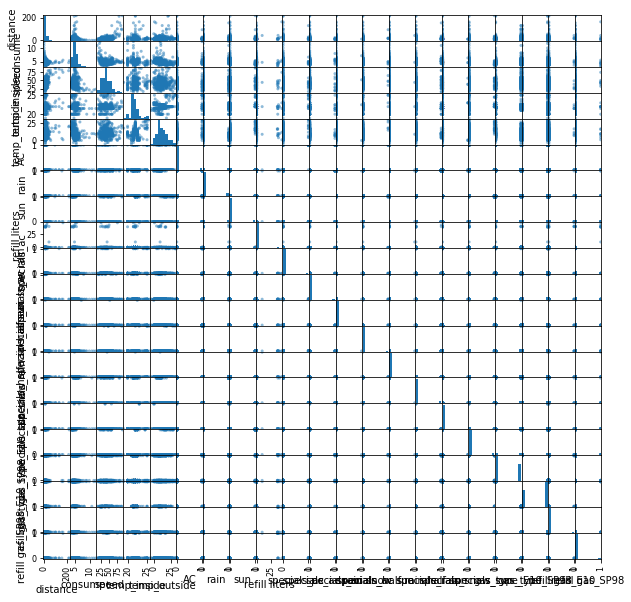

In [199]:
# 散布図行列を描画
pd.plotting.scatter_matrix(df, figsize=(10,10))
plt.show()

## 相関係数を表示

- pandas の corr 関数を利用

In [200]:
# 相関係数を確認
df.corr()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,specials_ac,...,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_rain,specials_snow,specials_sun,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98
distance,1.000000,-0.128967,0.562299,0.075178,0.088175,-0.025738,-0.019791,0.081120,0.107045,0.038373,...,-0.016510,0.072108,0.053996,0.010723,-0.029320,0.055737,0.053411,-0.053411,0.026079,0.106134
consume,-0.128967,1.000000,-0.227866,-0.160623,-0.320811,0.096591,0.248118,-0.170667,-0.074095,-0.042500,...,0.107772,-0.036804,-0.010462,0.157122,0.021755,-0.168194,0.015327,-0.015327,-0.025731,-0.079080
speed,0.562299,-0.227866,1.000000,0.059293,0.015411,-0.035408,0.009489,0.081618,-0.007446,-0.060027,...,0.037700,0.123438,0.007756,0.038156,0.015635,0.033523,0.097360,-0.097360,-0.073428,0.046177
temp_inside,0.075178,-0.160623,0.059293,1.000000,0.359500,0.297376,-0.036937,0.242248,-0.021348,0.312831,...,0.029192,0.249646,0.003606,-0.068993,0.095124,0.151238,-0.010198,0.010198,-0.014897,-0.017092
temp_outside,0.088175,-0.320811,0.015411,0.359500,1.000000,0.167562,-0.186315,0.346903,-0.041595,0.235493,...,-0.082688,0.167590,-0.017168,-0.122726,-0.139378,0.300752,-0.148705,0.148705,-0.009135,-0.043809
AC,-0.025738,0.096591,-0.035408,0.297376,0.167562,1.000000,0.242915,0.088598,-0.052571,0.616618,...,0.175600,0.394699,-0.014715,-0.086790,-0.025553,-0.079168,-0.105285,0.105285,-0.033075,-0.042002
rain,-0.019791,0.248118,0.009489,-0.036937,-0.186315,0.242915,1.000000,-0.112650,0.033505,-0.072696,...,0.135289,-0.042931,0.135289,0.797937,0.234936,-0.102757,-0.060328,0.060328,0.026474,0.055653
sun,0.081120,-0.170667,0.081618,0.242248,0.346903,0.088598,-0.112650,1.000000,-0.054448,-0.058007,...,-0.015240,0.381097,-0.015240,-0.089888,-0.026466,0.912175,-0.022761,0.022761,-0.034256,-0.043501
refill liters,0.107045,-0.074095,-0.007446,-0.021348,-0.041595,-0.052571,0.033505,-0.054448,1.000000,-0.035136,...,-0.009232,-0.020750,0.065003,0.053644,-0.016031,-0.049666,-0.000741,0.000741,0.640010,0.727194
specials_ac,0.038373,-0.042500,-0.060027,0.312831,0.235493,0.616618,-0.072696,-0.058007,-0.035136,1.000000,...,-0.009835,-0.022106,-0.009835,-0.058007,-0.017079,-0.052912,-0.105929,0.105929,-0.022106,-0.028073


## 相関係数をヒートマップにして可視化

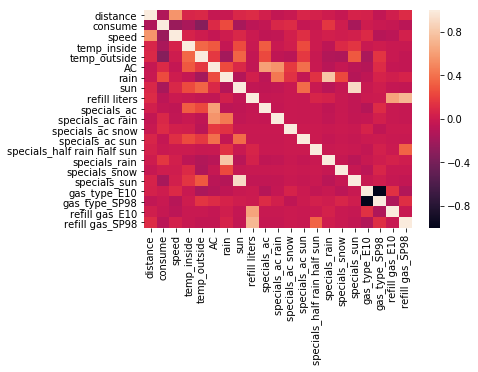

In [201]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df.corr())
plt.show()

## 学習用データと検証用データに分割

- 目的変数
  - consume
- 説明変数
  - いったん、consume 以外のすべてのカラムを採用

In [202]:
# 目的変数（ numpy の array に変換）
y = df["consume"].values
# 説明変数（ numpy の array に変換）
X = df.drop("consume", axis=1).values

# データ全体の 2割を検証用データ、残りを学習用データとする
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

## ステップワイズ法による特徴選択

In [203]:
# estimatorにモデルをセット（ LinearRegression を使用（でよいのか？？？）
estimator = LinearRegression(normalize=False)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')

# fitで特徴選択を実行
rfecv.fit(X_train, y_train)

## 特徴のランキングをカラム名と合わせて表示（1が最も重要な特徴）
df_columns_rfe = pd.DataFrame(data=df.drop("consume", axis=1).columns, columns=['column'])
df_columns_rfe['ranking'] = rfecv.ranking_
display(df_columns_rfe)

,column,ranking
0,distance,3
1,speed,2
2,temp_inside,1
3,temp_outside,1
4,AC,1
5,rain,1
6,sun,1
7,refill liters,1
8,specials_ac,1
9,specials_ac rain,1


- 予想に反して distance、speed のランキングが低い、という結果になった

## LASSOによる特徴選択

In [204]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 係数のしきい値はthresholdで指定する
threshold = 1e-8 #1e-5
sfm = SelectFromModel(estimator, threshold=threshold)

# fitで特徴選択を実行
sfm.fit(X_train, y_train)

## 各カラムの使用・削除を True/False で、をカラム名と合わせて表示（True：使用すべき。False：削除すべき）
df_columns_lasso = pd.DataFrame(data=df.drop("consume", axis=1).columns, columns=['column'])
df_columns_lasso['support'] = sfm.get_support()
display(df_columns_lasso)

/Users/nakayama/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,column,support
0,distance,False
1,speed,True
2,temp_inside,True
3,temp_outside,True
4,AC,True
5,rain,True
6,sun,False
7,refill liters,True
8,specials_ac,False
9,specials_ac rain,False


- 想定以上に False のカラムが多い（ threshold を小さくしても傾向は同様であった）

- いったんこれらは参考情報とする

## ランダムフォレストモデルで学習

- ハイパーパラメータはデフォルト値を採用する

Random Forest (Default) score = 0.941


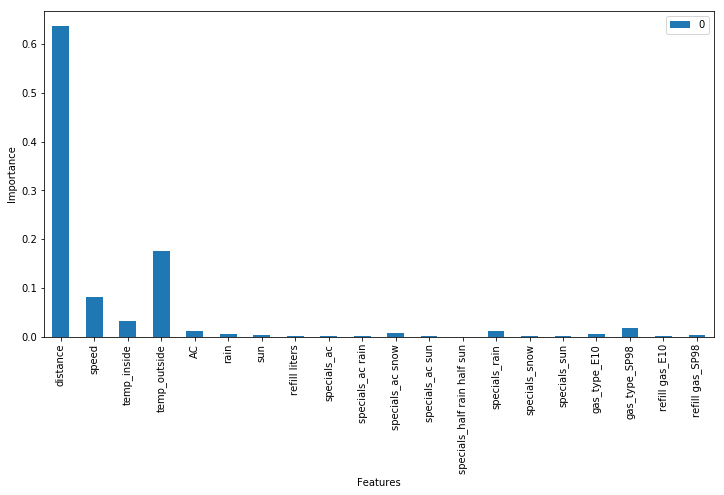

Random Forest (Default) RMSE = 0.708


In [205]:
# ハイパーパラメータはデフォルト値を採用
regressor = RandomForestRegressor(random_state=1234)

regressor.fit(X_train, y_train)
print("Random Forest (Default) score = %s" % round(regressor.score(X_train, y_train), 3))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
#print(regressor.feature_importances_)
pd.DataFrame(regressor.feature_importances_, index=df.drop("consume", axis=1).columns).plot.bar(figsize=(12,6))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

# テストデータに対する予測を実行
y_pred_test = regressor.predict(X_test)

# テストデータに対するMSEを計算
mse = mean_squared_error(y_test, y_pred_test) 
# テストデータに対するRMSEを計算
rmse_random_forest_default = np.sqrt(mse)
print("Random Forest (Default) RMSE = %s"%round(rmse_random_forest_default, 3))

## アダブーストモデルで学習

- ハイパーパラメータはデフォルト値を採用する

AdaBoost (Default) score = 0.998


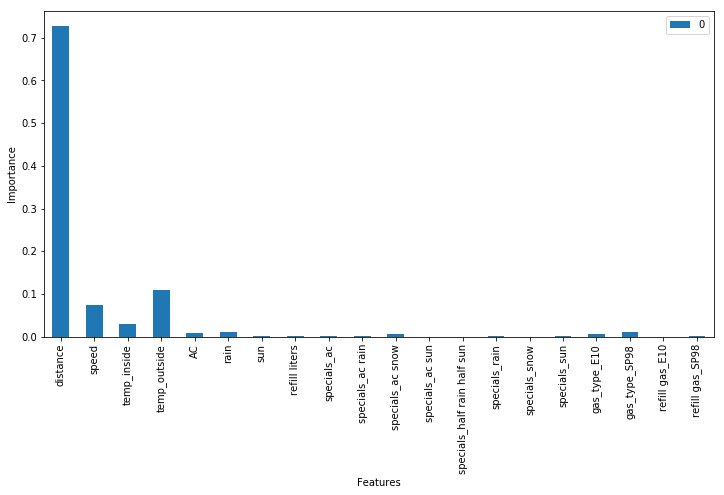

AdaBoost (Default) RMSE = 0.695


In [206]:
regressor = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=1234), random_state=1234)
regressor.fit(X_train, y_train)
print("AdaBoost (Default) score = %s" % round(regressor.score(X_train, y_train), 3))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
#print(regressor.feature_importances_)
pd.DataFrame(regressor.feature_importances_, index=df.drop("consume", axis=1).columns).plot.bar(figsize=(12,6))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()
                         
# テストデータに対する予測を実行
y_pred_test = regressor.predict(X_test)

# テストデータに対するMSEを計算
mse = mean_squared_error(y_test, y_pred_test) 
# テストデータに対するRMSEを計算
rmse_adaboost_default = np.sqrt(mse)
print("AdaBoost (Default) RMSE = %s"%round(rmse_adaboost_default, 3))

## ランダムフォレストモデルで学習（ GridSearchCV でハイパーパラメータをチューニング）

In [207]:
# チューニング対象のパラメータ
parameters = {
    "n_estimators": [ 5, 10, 20 ],
    "criterion": [ "mse", "mae" ],
    "max_depth": [ 8, 12, 16 ],
    "min_samples_split": [ 2, 4, 8, 12 ],
    "min_samples_leaf": [ 1, 2, 4 ]
}

# ランダムフォレストモデルで学習（ GridSearchCV でハイパーパラメータをチューニング）
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=1234), param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# いちばんよいスコアを表示
print("Random Forest (Tuned) Best Score: %s" % grid_search.best_score_)
# いちばんよいパラメータの組み合わせを表示
print("Random Forest (Tuned) Best Parameters: ")
display(grid_search.best_params_)

# 一番良いモデルを取得
best_estimator = grid_search.best_estimator_

# テストデータに対する予測を実行
y_pred_test = best_estimator.predict(X_test)

# テストデータに対するMSEを計算
mse = mean_squared_error(y_test, y_pred_test) 
# テストデータに対するRMSEを計算
rmse_random_forest_tuned = np.sqrt(mse)
print("Random Forest (Tuned) RMSE = %s"%round(rmse_random_forest_tuned, 3))

Random Forest (Tuned) Best Score: 0.5341891701710852
Random Forest (Tuned) Best Parameters: 


{'criterion': 'mae',
 'max_depth': 16,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 10}

Random Forest (Tuned) RMSE = 0.67


## アダブーストモデルで学習（ GridSearchCV でハイパーパラメータをチューニング）

In [208]:
# チューニング対象のパラメータ
parameters = {
    "n_estimators": [ 30, 50, 70 ],
    "base_estimator__criterion": [ "mse", "mae" ],
    "base_estimator__max_depth": [ 8, 12, 16 ],
    "base_estimator__min_samples_split": [ 4, 8, 12, 16 ],
    "base_estimator__min_samples_leaf": [ 2, 4, 8 ]
}

# アダブーストモデルで学習（ GridSearchCV でハイパーパラメータをチューニング）
grid_search = GridSearchCV(estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=1234), random_state=1234), 
                           param_grid=parameters, 
                           cv=5, 
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

# いちばんよいスコアを表示
print("AdaBoost (Tuned) Best Score: %s" % grid_search.best_score_)
# いちばんよいパラメータの組み合わせを表示
print("AdaBoost (Tuned) Best Parameters: ")
display(grid_search.best_params_)

# 一番良いモデルを取得
best_estimator = grid_search.best_estimator_

# テストデータに対する予測を実行
y_pred_test = best_estimator.predict(X_test)

# テストデータに対するMSEを計算
mse = mean_squared_error(y_test, y_pred_test) 
# テストデータに対するRMSEを計算
rmse_adaboost_tuned = np.sqrt(mse)
print("AdaBoost (Tuned) RMSE = %s"%round(rmse_adaboost_tuned, 3))

AdaBoost (Tuned) Best Score: 0.5102486463594554
AdaBoost (Tuned) Best Parameters: 


{'base_estimator__criterion': 'mae',
 'base_estimator__max_depth': 16,
 'base_estimator__min_samples_leaf': 4,
 'base_estimator__min_samples_split': 16,
 'n_estimators': 50}

AdaBoost (Tuned) RMSE = 0.713


## ランダムフォレストモデルで学習（ ハイパーパラメータをチューニング、説明変数を限定）

- Importance の値が高い説明変数のみを対象として、学習を実施
  - distance、speed、temp_inside、temp_outside、AC、rain、sun、specials_ac snow、specials_rain、gas_type_E10、gas_type_SP98、refill gas_SP98 を採用

In [209]:
# 不要な説明変数を削除
X_train_param_limited = np.delete(X_train, [7, 8, 9, 11, 12, 14, 15, 18], axis=1)
# 検証用データも、学習用データと同じ列数にしないと predict 関数実行時にエラーとなったため、そろえる
X_test_param_limited = np.delete(X_test, [7, 8, 9, 11, 12, 14, 15, 18], axis=1)

# チューニング対象のパラメータ
parameters = {
    "n_estimators": [ 5, 10, 20 ],
    "criterion": [ "mse", "mae" ],
    "max_depth": [ 8, 12, 16 ],
    "min_samples_split": [ 2, 4, 8, 12 ],
    "min_samples_leaf": [ 1, 2, 4 ]
}

# ランダムフォレストモデルで学習（ GridSearchCV でハイパーパラメータをチューニング）
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=1234), param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train_param_limited, y_train)

# いちばんよいスコアを表示
print("Random Forest (Param Limited) Best Score: %s" % grid_search.best_score_)
# いちばんよいパラメータの組み合わせを表示
print("Random Forest (Param Limited) Best Parameters: ")
display(grid_search.best_params_)

# 一番良いモデルを取得
best_estimator = grid_search.best_estimator_

# テストデータに対する予測を実行
y_pred_test = best_estimator.predict(X_test_param_limited)

# テストデータに対するMSEを計算
mse = mean_squared_error(y_test, y_pred_test) 
# テストデータに対するRMSEを計算
rmse_random_forest_param_limited = np.sqrt(mse)
print("Random Forest (Param Limited) RMSE = %s"%round(rmse_random_forest_param_limited, 3))

Random Forest (Param Limited) Best Score: 0.5317470076099942
Random Forest (Param Limited) Best Parameters: 


{'criterion': 'mae',
 'max_depth': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 10}

Random Forest (Param Limited) RMSE = 0.657


## アダブーストモデルで学習（ ハイパーパラメータをチューニング、説明変数を限定）

- Importance の値が高い説明変数のみを対象として、学習を実施
  - distance、speed、temp_inside、temp_outside、AC、rain、sun、specials_ac snow、specials_rain、gas_type_E10、gas_type_SP98、refill gas_SP98 を採用

In [210]:
# チューニング対象のパラメータ
parameters = {
    "n_estimators": [ 30, 50, 70 ],
    "base_estimator__criterion": [ "mse", "mae" ],
    "base_estimator__max_depth": [ 8, 12, 16 ],
    "base_estimator__min_samples_split": [ 4, 8, 12, 16 ],
    "base_estimator__min_samples_leaf": [ 2, 4, 8 ]
}

# アダブーストモデルで学習（ GridSearchCV でハイパーパラメータをチューニング）
grid_search = GridSearchCV(estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=1234), random_state=1234), 
                           param_grid=parameters, 
                           cv=5, 
                           n_jobs=-1)
grid_search.fit(X_train_param_limited, y_train)

# いちばんよいスコアを表示
print("AdaBoost (Param Limited) Best Score: %s" % grid_search.best_score_)
# いちばんよいパラメータの組み合わせを表示
print("AdaBoost (Param Limited) Best Parameters: ")
display(grid_search.best_params_)

# 一番良いモデルを取得
best_estimator = grid_search.best_estimator_

# テストデータに対する予測を実行
y_pred_test = best_estimator.predict(X_test_param_limited)

# テストデータに対するMSEを計算
mse = mean_squared_error(y_test, y_pred_test) 
# テストデータに対するRMSEを計算
rmse_adaboost_param_limited = np.sqrt(mse)
print("AdaBoost (Param Limited) RMSE = %s"%round(rmse_adaboost_param_limited, 3))

AdaBoost (Param Limited) Best Score: 0.5263736317480782
AdaBoost (Param Limited) Best Parameters: 


{'base_estimator__criterion': 'mse',
 'base_estimator__max_depth': 8,
 'base_estimator__min_samples_leaf': 4,
 'base_estimator__min_samples_split': 16,
 'n_estimators': 30}

AdaBoost (Param Limited) RMSE = 0.788


## まとめ

In [212]:
print("1, ランダムフォレスト(パラメータはデフォルトのまま) RMSE = %s"%round(rmse_random_forest_default, 3))
print("2. アダブースト (パラメータはデフォルトのまま) RMSE = %s"%round(rmse_adaboost_default, 3))
print("3, ランダムフォレスト(パラメータ調整後) RMSE = %s"%round(rmse_random_forest_tuned, 3))
print("4, アダブースト(パラメータ調整後) RMSE = %s"%round(rmse_adaboost_tuned, 3))
print("5, ランダムフォレスト(パラメータ調整、説明変数限定) RMSE = %s"%round(rmse_random_forest_param_limited, 3))
print("6. アダブースト(パラメータ調整、説明変数限定) RMSE = %s"%round(rmse_adaboost_param_limited, 3))

1, ランダムフォレスト(パラメータはデフォルトのまま) RMSE = 0.708
2. アダブースト (パラメータはデフォルトのまま) RMSE = 0.695
3, ランダムフォレスト(パラメータ調整後) RMSE = 0.67
4, アダブースト(パラメータ調整後) RMSE = 0.713
5, ランダムフォレスト(パラメータ調整、説明変数限定) RMSE = 0.657
6. アダブースト(パラメータ調整、説明変数限定) RMSE = 0.788


- 「6.」の、パラメータ調整、かつ説明変数を限定した、ランダムフォレストのパターンの RMSE が **0.657** となり、いちばんよい結果となった。
  - （ただ、説明変数を絞り込んだ「5.」「6.」のパターンは、train_test_split 関数によって学習用データと検証用データに分割したのちに、一部、検証用データを加工している（変数の列をいくつか削除している）ため、厳密にいうと（検証用データを分けた後はそれを編集しない、という）ルールに抵触している？？？）
  - 「5.」「6.」を除くと、「3.」の、ランダムフォレスト(パラメータ調整あり)パターンが、0.67 で、いちばんよい。